# Patching WSI

In [ ]:
#| default_exp nb_02_patching

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path

In [ ]:
#| export
from ml.nb_01_processing import *

In [ ]:
#| export
import pandas as pd

In [ ]:
#| export
import matplotlib.pylab as plt

In [ ]:
import numpy as np

In [ ]:
df = pd.read_pickle("data/df_all_2022_10_06.pkl")
df.shape

(1180, 95)

In [ ]:
#from PIL import Image

In [ ]:
imgx_fn = df.fn_x[1]
imgy_fn = df.fn_y[1]

## Patching

In [ ]:
#| export 
import cv2

In [ ]:
#|export
Path.str = lambda x: str(x)

In [ ]:
imgx = cv2.imread(imgx_fn.str())
imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)

imgy = cv2.imread(imgy_fn.str())
imgy = cv2.cvtColor(imgy, cv2.COLOR_BGR2RGB)

In [ ]:
imgx.shape

(5376, 5120, 3)

In [ ]:
#| export
import ipyplot

In [ ]:
#| export
def tile(img, mask, sz=128, N = 32):
    result = []
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=0)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz,3)
    mask = mask.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        mask = np.pad(mask,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=0)
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
        
    timg = img.reshape(img.shape[0],-1)
    tmask = mask.reshape(mask.shape[0],-1)
       
    idxs = np.argsort(~np.sum(tmask, axis=1))[:N]
    img = img[idxs]
    mask = mask[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'mask':mask[i], 'idx':i})
    return result


In [ ]:
res = tile(imgx, imgy)

In [ ]:
images = list(map(lambda x: x["img"], res))
masks = list(map(lambda x: x["mask"]/np.max(x["mask"]), res))

In [ ]:
len(res)

32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


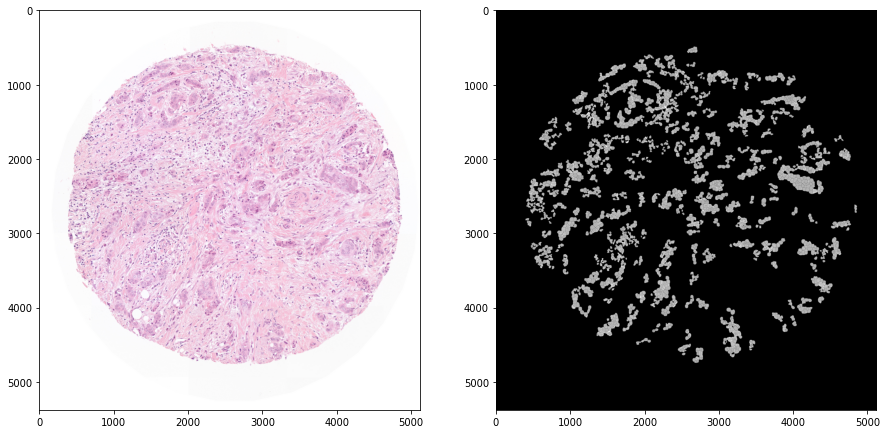

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15, 10))
axs[0].imshow(imgx);
axs[1].imshow(imgy/20);


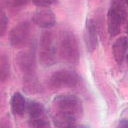
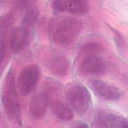
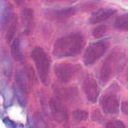
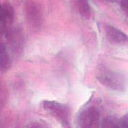
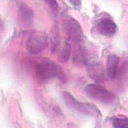
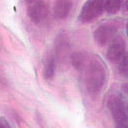
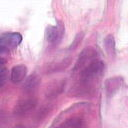
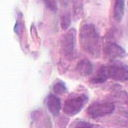
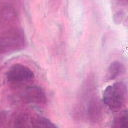
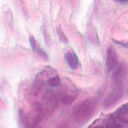
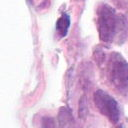
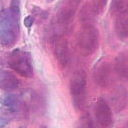
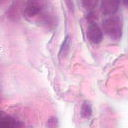
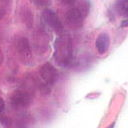
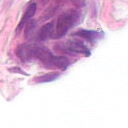
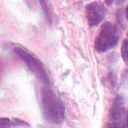
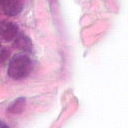
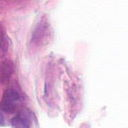
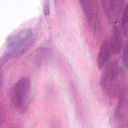
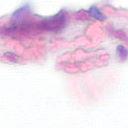
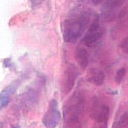
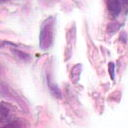
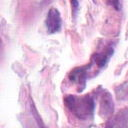
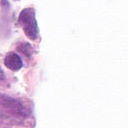
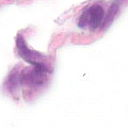
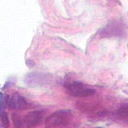
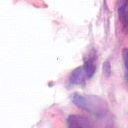
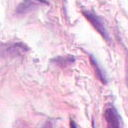
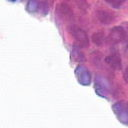
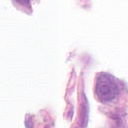


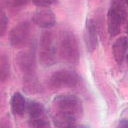
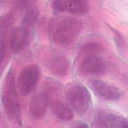
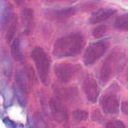
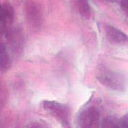
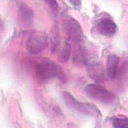
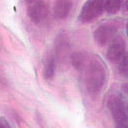
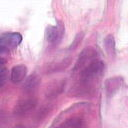
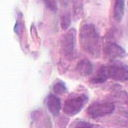
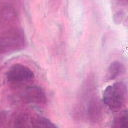
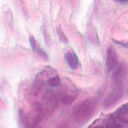
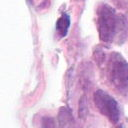
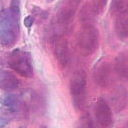
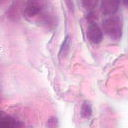
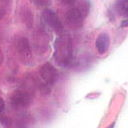
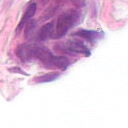
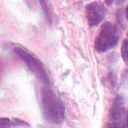
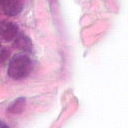
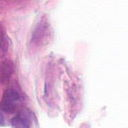
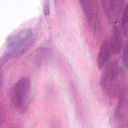
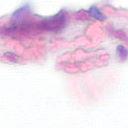
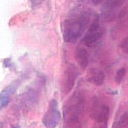
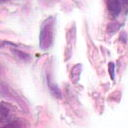
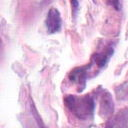
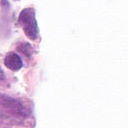
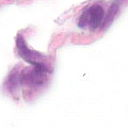
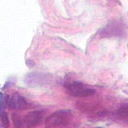
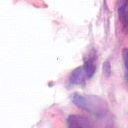
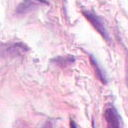
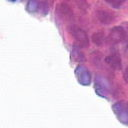
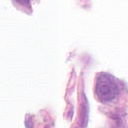

In [ ]:
ipyplot.plot_images(images)


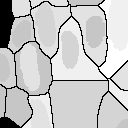
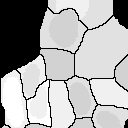
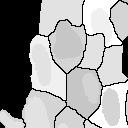
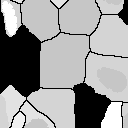
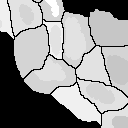
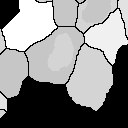
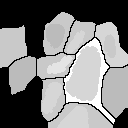
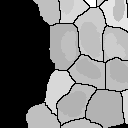
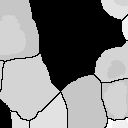
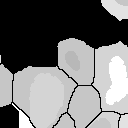
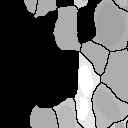
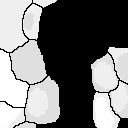
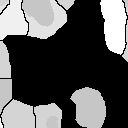
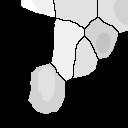
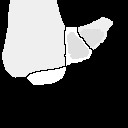
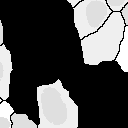
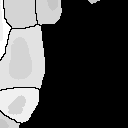
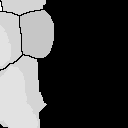
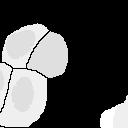
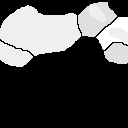
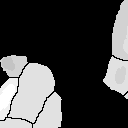
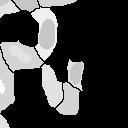
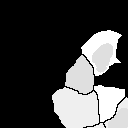
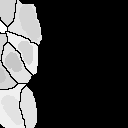
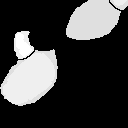
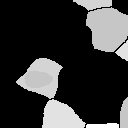
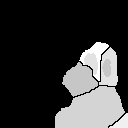
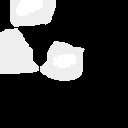
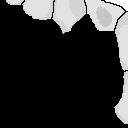
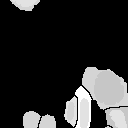


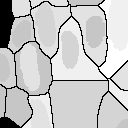
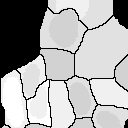
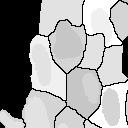
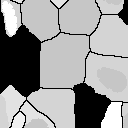
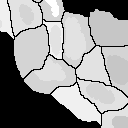
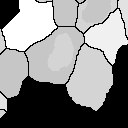
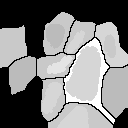
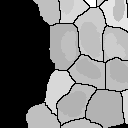
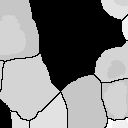
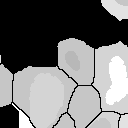
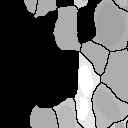
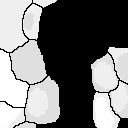
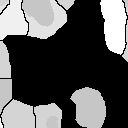
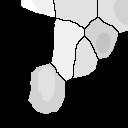
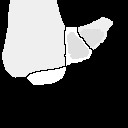
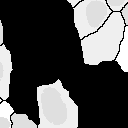
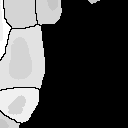
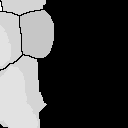
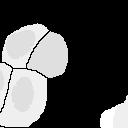
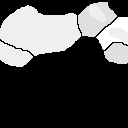
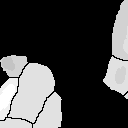
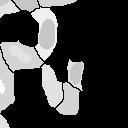
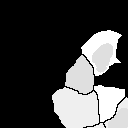
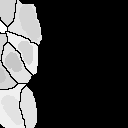
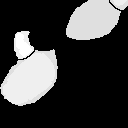
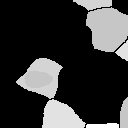
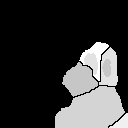
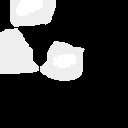
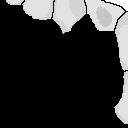
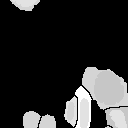

In [ ]:
ipyplot.plot_images(masks)

In [ ]:
p_outx = Path("/media/dimi/TOSHIBA EXT/patched_images")
p_outy = Path("/media/dimi/TOSHIBA EXT/patched_masks")

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
from PIL import Image

In [ ]:
x_tot,x2_tot = [],[]
y_tot,y2_tot = [],[]


for i in tqdm.notebook.tqdm(range(df.shape[0])):
        
    imgx_fn = df.fn_x[i]
    imgy_fn = df.fn_y[i]
    
    imgx = cv2.imread(imgx_fn.str())
    imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
    
    imgy = cv2.imread(imgy_fn.str())
    imgy = cv2.cvtColor(imgy, cv2.COLOR_BGR2RGB)
    
    tiles = tile(imgx, imgy)
    
    for t in tiles:
            
        img,mask,idx = t['img'],t['mask'],t['idx']
        
        x_tot.append((img/255.0).reshape(-1,3).mean(0))
        x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0)) 
        
        y_tot.append((mask/1000.0).reshape(-1,3).mean(0))
        y2_tot.append(((mask/1000.0)**2).reshape(-1,3).mean(0)) 
        
        #mask = mask/np.max(mask)
        
        #if read with PIL RGB turns into BGR
        im = Image.fromarray(img)
        im.save(p_outx.str()+"/"+df.TMA_ID[i]+"_"+df.TMASpot[i]+"_"+str(idx)+".png")
        
        ma = Image.fromarray(mask)
        ma.save(p_outy.str()+"/"+df.TMA_ID[i]+"_"+df.TMASpot[i]+"_"+str(idx)+".png")

/tmp/ipykernel_23035/1009390068.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(df.shape[0])):


  0%|          | 0/1180 [00:00<?, ?it/s]

## Save

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()